In [32]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything
from pathlib import Path
from skimage.io import imread

import torch
torch.set_float32_matmul_precision("high")
  
seed_everything(1337)
scvi.settings.seed = 1337

Seed set to 1337
Seed set to 1337


# Preparing data

In [33]:
# # LAPTOP
# segmentation_path = Path("/Users/janzules/Roselab/Spatial/CAR_T/data/cell_segmentation/")

# COMPUTER
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/cell_segmentation/")
adata_file     = segmentation_path / "concatenated" / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/clustering_results/")
ST_sample = sc.read_h5ad(adata_file)

# ST_sample = ST_sample_org[ST_sample_org.obs['mouse'].isin([sample])].copy()
# del ST_sample_org

## Adding images

In [34]:
# C:/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1

# "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/"

In [35]:
# # LAPTOP
# HNE_TIF_PATHS = {
#     "F07839": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA4_Slide_1.tif"),
#     "F07840": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA5_Slide_1.tif")
# }

# COMPUTER
HNE_TIF_PATHS = {
    "F07839": Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA4_Slide_1.tif"),
    "F07840": Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA5_Slide_1.tif")
}



In [36]:
ST_sample.obsm["spatial"] = ST_sample.obs[["cx", "cy"]].to_numpy()

In [37]:
# 1) Make sure your AnnData knows which “library” (TMA) each spot comes from.
#    We’ll use your existing 'TMA' column as the library_key:
ST_sample.obs['library_id'] = ST_sample.obs['TMA']

# 2) Build the minimal `adata.uns['spatial']` structure Squidpy expects:
#    For each TMA, point to your H&E image (as a numpy array) and set a scale factor.
ST_sample.uns['spatial'] = {}
for lib_id, tif_path in HNE_TIF_PATHS.items():
    img = imread(tif_path)
    ST_sample.uns['spatial'][lib_id] = {
        "images": {"hires": img},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 100.0,   # <- add this
            "tissue_lowres_scalef": 1.0,      # <- add this (not always needed)
        }
    }

In [38]:
sc.pp.filter_genes(ST_sample, min_counts=3)
sc.pp.filter_cells(ST_sample, min_counts=50)

In [ ]:
ST_sample.layers['counts'] = ST_sample.X.copy()

sc.pp.normalize_total(ST_sample, target_sum=1e6)
sc.pp.log1p(ST_sample)

# Dimensionality Reduction

In [41]:
scvi.model.SCVI.setup_anndata(
    ST_sample,
    layer="counts",
    batch_key="mouse"
)

model = scvi.model.SCVI(ST_sample)

In [42]:
# # LAPTOP
# model.train(early_stopping=True, enable_progress_bar=True, accelerator="mps")

# COMPUTER
model.train(early_stopping=True, enable_progress_bar=True, accelerator="cuda")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47/47: 100%|██████| 47/47 [13:29<00:00, 16.82s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]

`Trainer.fit` stopped: `max_epochs=47` reached.


Epoch 47/47: 100%|██████| 47/47 [13:29<00:00, 17.22s/it, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.05e+3]


In [43]:
ST_sample.obsm['X_scVI'] = model.get_latent_representation(ST_sample).astype(np.float32)

In [44]:
# sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True)
sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

# CellCharter's spatial clustering

In [45]:
# grabbing coords for CyPSCA_1_2

# Adjust this column name if needed
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# Extract (cx, cy) coordinates
coords = subset.obsm['spatial']

# Compute bounding box
xmin = np.min(coords[:, 0])
xmax = np.max(coords[:, 0])
ymin = np.min(coords[:, 1])
ymax = np.max(coords[:, 1])

print(f"xmin: {xmin}, xmax: {xmax}")
print(f"ymin: {ymin}, ymax: {ymax}")


xmin: 3116.4631871012366, xmax: 8908.762357234882
ymin: 3833.2490728455214, ymax: 6528.459009738141


In [46]:
# 1. Subset AnnData for the target mouse/condition
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# 2. Extract spatial coordinates
coords = subset.obsm['spatial']
xmin, xmax = coords[:, 0].min(), coords[:, 0].max()
ymin, ymax = coords[:, 1].min(), coords[:, 1].max()

# Optional: Add margin (e.g., 100 pixels on each side)
margin = 100
crop_coord = (
    int(xmin - margin),
    int(ymin - margin),
    int(xmax + margin),
    int(ymax + margin)
)

print("Crop coordinates:", crop_coord)


Crop coordinates: (3016, 3733, 9008, 6628)


In [47]:
# Get the unique TMA(s) that contain this mouse
ST_sample.obs.loc[ST_sample.obs['mouse'] == 'CyPSCA_1_2', 'TMA'].unique()

['F07840']
Categories (2, object): ['F07839', 'F07840']

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


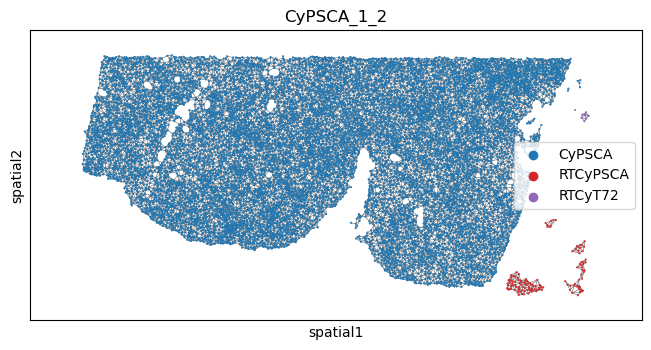

In [48]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [49]:
cc.gr.remove_long_links(ST_sample)

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


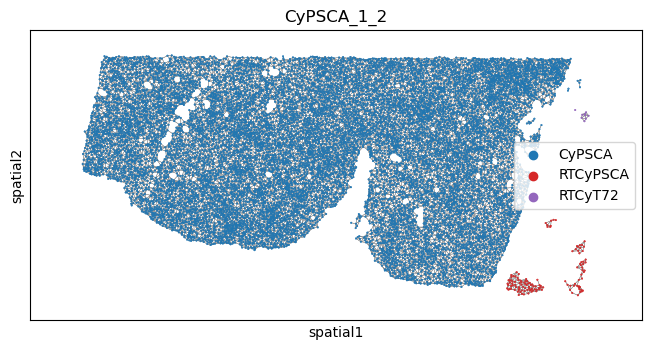

In [50]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [51]:
# output = segmentation_path / "scvi_all.h5ad"

In [52]:
# ST_sample.write(output)

# Clustering

In [53]:
# ST_sample = sc.read_h5ad("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/cell_segmentation/concatenated/scvi_all.h5ad")

In [54]:
# sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

In [55]:
cc.gr.aggregate_neighbors(ST_sample, n_layers=1, use_rep='X_scVI', out_key='X_cellcharter', sample_key='mouse')

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.34it/s]


In [56]:
# https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html?utm_source=chatgpt.com
model_params = {
    "random_state": 1337,
    "trainer_params": {
        "accelerator": "cuda",   # or "cuda" depending on PL version
        "devices": 1,          # number of GPUs to use
        "enable_progress_bar": True
    }
}


autok = cc.tl.ClusterAutoK(
    n_clusters=(2,20),
    max_runs=10,
    convergence_tol=0.001,
    model_class=cc.tl.GaussianMixture,
    model_params=model_params
)


In [57]:
autok.fit(ST_sample, 
          use_rep='X_cellcharter')

Iteration 1/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.28it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.94it/s]

  5%|███▊                                                                            | 1/21 [00:03<01:08,  3.44s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.01it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.89it/s]


 10%|███████▌                                                                        | 2/21 [00:06<01:02,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.71it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.67it/s]


 14%|███████████▍                                                                    | 3/21 [00:09<00:58,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.72it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.56it/s]

 19%|███████████████▏                                                                | 4/21 [00:13<00:57,  3.37s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.98it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.53it/s]


 24%|███████████████████                                                             | 5/21 [00:16<00:53,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.43it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.24it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:19<00:49,  3.31s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.05it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 106.42it/s]

 33%|██████████████████████████▋                                                     | 7/21 [00:23<00:45,  3.28s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.07it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.49it/s]

 38%|██████████████████████████████▍                                                 | 8/21 [00:26<00:42,  3.27s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.20it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.74it/s]

 43%|██████████████████████████████████▎                                             | 9/21 [00:30<00:40,  3.39s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.79it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.22it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:33<00:37,  3.44s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.72it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.22it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:36<00:33,  3.40s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.31it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.49it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:40<00:30,  3.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.33it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.55it/s]

 62%|████████████████████████████████████████████████▉                              | 13/21 [00:43<00:26,  3.35s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.30it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.70it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:46<00:23,  3.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.25it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 130.63it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:50<00:20,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.44it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.37it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:53<00:17,  3.44s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.17it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.23it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:57<00:14,  3.54s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.20it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.53it/s]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [01:01<00:10,  3.61s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.72it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.46it/s]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:05<00:07,  3.73s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.45it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.79it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:09<00:03,  3.85s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.34it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:13<00:00,  3.50s/it]


Iteration 2/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.81it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 228.76it/s]

  5%|███▊                                                                            | 1/21 [00:01<00:29,  1.46s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.81it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.01it/s]


 10%|███████▌                                                                        | 2/21 [00:04<00:44,  2.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.01it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 206.45it/s]


 14%|███████████▍                                                                    | 3/21 [00:07<00:47,  2.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.76it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.71it/s]

 19%|███████████████▏                                                                | 4/21 [00:10<00:48,  2.84s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 106.45it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.60it/s]


 24%|███████████████████                                                             | 5/21 [00:13<00:48,  3.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.52it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.66it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:16<00:44,  3.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.53it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.06it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:19<00:42,  3.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 31: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.66it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.08it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:23<00:39,  3.07s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.03it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.40it/s]

 43%|██████████████████████████████████▎                                             | 9/21 [00:26<00:37,  3.10s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.06it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.41it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:29<00:34,  3.14s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.09it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.47it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:32<00:31,  3.20s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.01it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.24it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:36<00:29,  3.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.65it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.03it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:39<00:25,  3.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.92it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.03it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:42<00:22,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.65it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.47it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:46<00:19,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 61: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.28it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.44it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:49<00:16,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.47it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.50it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:53<00:13,  3.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.49it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.78it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:56<00:10,  3.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 69: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.35it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.79it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:00<00:07,  3.58s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.53it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.47it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:04<00:03,  3.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.15it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.47it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:08<00:00,  3.25s/it]


Iteration 3/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.50it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.19it/s]

  5%|███▊                                                                            | 1/21 [00:02<00:57,  2.86s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.06it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.72it/s]


 10%|███████▌                                                                        | 2/21 [00:05<00:56,  2.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.45it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.03it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:53,  3.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.20it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.37it/s]


 19%|███████████████▏                                                                | 4/21 [00:12<00:53,  3.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.41it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.37it/s]


 24%|███████████████████                                                             | 5/21 [00:15<00:52,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.65it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.70it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:18<00:48,  3.21s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.44it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.18it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:22<00:44,  3.21s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.32it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.75it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:25<00:42,  3.24s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.05it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.89it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:28<00:39,  3.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.77it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.79it/s]

 48%|█████████████████████████████████████▌                                         | 10/21 [00:31<00:35,  3.24s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.38it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.99it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:35<00:32,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.37it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.93it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:38<00:30,  3.34s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.49it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.83it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:42<00:26,  3.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.42it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.75it/s]

 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:45<00:23,  3.39s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.22it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.73it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:49<00:20,  3.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.61it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.40it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:52<00:17,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.31it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.91it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:56<00:13,  3.46s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.94it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.21it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:59<00:10,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.94it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.42it/s]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:02<00:06,  3.44s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.38it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.93it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:06<00:03,  3.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.47it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.34s/it]

Iteration 4/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.02it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 234.59it/s]

  5%|███▊                                                                            | 1/21 [00:02<00:57,  2.89s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.28it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.19it/s]


 10%|███████▌                                                                        | 2/21 [00:05<00:55,  2.94s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.03it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.78it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:53,  2.98s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.80it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.65it/s]


 19%|███████████████▏                                                                | 4/21 [00:12<00:53,  3.13s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.69it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.57it/s]


 24%|███████████████████                                                             | 5/21 [00:15<00:50,  3.17s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.93it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.63it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:18<00:47,  3.16s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.79it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.75it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:21<00:44,  3.17s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 31: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.37it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.86it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:24<00:41,  3.16s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.54it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.08it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:28<00:38,  3.20s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.50it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:31<00:35,  3.22s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.63it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.60it/s]

 52%|█████████████████████████████████████████▍                                     | 11/21 [00:34<00:32,  3.28s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.90it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.65it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:38<00:29,  3.29s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.87it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.56it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:41<00:26,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.62it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.59it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:44<00:23,  3.29s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.42it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 122.08it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:48<00:19,  3.30s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.36it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.59it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:51<00:16,  3.34s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 67: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.11it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.00it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:55<00:13,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.91it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.31it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:58<00:10,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.90it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.99it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:02<00:07,  3.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 65: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.42it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:06<00:03,  3.63s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.34s/it]


Iteration 5/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.47it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.87it/s]

  5%|███▊                                                                            | 1/21 [00:02<00:59,  2.96s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.94it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.83it/s]


 10%|███████▌                                                                        | 2/21 [00:04<00:44,  2.33s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.27it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.10it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:48,  2.71s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.92it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.17it/s]


 19%|███████████████▏                                                                | 4/21 [00:11<00:50,  2.95s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.97it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.37it/s]


 24%|███████████████████                                                             | 5/21 [00:14<00:51,  3.20s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.39it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.90it/s]

 29%|██████████████████████▊                                                         | 6/21 [00:18<00:49,  3.32s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.60it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.99it/s]

 33%|██████████████████████████▋                                                     | 7/21 [00:22<00:47,  3.39s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.00it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.48it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:25<00:45,  3.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.57it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.99it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:29<00:42,  3.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.78it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.37it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:33<00:39,  3.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.39it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.13it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:36<00:36,  3.61s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.89it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.79it/s]

 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:40<00:32,  3.61s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.60it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.79it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:44<00:29,  3.65s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.16it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.20it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:47<00:25,  3.68s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.91it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.97it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:51<00:22,  3.70s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.17it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.66it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:55<00:18,  3.68s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 67: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.92it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.01it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:59<00:15,  3.75s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.63it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.40it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [01:02<00:11,  3.76s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.09it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.49it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:06<00:07,  3.77s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.27it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:10<00:03,  3.71s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.71it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:12<00:00,  3.47s/it]

Iteration 6/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.72it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.67it/s]


  5%|███▊                                                                            | 1/21 [00:02<00:59,  2.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 69: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.01it/s, nll=19.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.36it/s]


 10%|███████▌                                                                        | 2/21 [00:06<01:02,  3.31s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.24it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.32it/s]

 14%|███████████▍                                                                    | 3/21 [00:09<00:59,  3.30s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.75it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.73it/s]


 19%|███████████████▏                                                                | 4/21 [00:13<00:57,  3.38s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.83it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.18it/s]

 24%|███████████████████                                                             | 5/21 [00:16<00:54,  3.41s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.21it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.52it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:20<00:51,  3.43s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.59it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.04it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:23<00:47,  3.40s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.74it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.89it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:27<00:44,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.95it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.96it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:30<00:41,  3.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.90it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.16it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:34<00:38,  3.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.59it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.52it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:37<00:34,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.16it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.06it/s]

 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:41<00:31,  3.53s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.63it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.71it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:44<00:28,  3.54s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.77it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.66it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:48<00:24,  3.53s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.56it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.23it/s]

 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:51<00:21,  3.54s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.15it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.39it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:55<00:18,  3.65s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.83it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.44it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:59<00:14,  3.72s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 65: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.18it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.62it/s]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [01:03<00:11,  3.85s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.42it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.53it/s]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:07<00:07,  3.75s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.22it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.26it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:11<00:03,  3.78s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.15it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:14<00:00,  3.57s/it]

Iteration 7/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.63it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 222.72it/s]

  5%|███▊                                                                            | 1/21 [00:02<00:54,  2.75s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.70it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.74it/s]


 10%|███████▌                                                                        | 2/21 [00:05<00:55,  2.91s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.24it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.37it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:53,  2.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.17it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.63it/s]


 19%|███████████████▏                                                                | 4/21 [00:12<00:52,  3.07s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.92it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.90it/s]


 24%|███████████████████                                                             | 5/21 [00:15<00:49,  3.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.37it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.13it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:18<00:46,  3.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.80it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.88it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:21<00:44,  3.19s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.52it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.81it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:24<00:41,  3.17s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.93it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.00it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:28<00:38,  3.23s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.23it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.53it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:31<00:35,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.41it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.79it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:34<00:32,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.08it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.52it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:38<00:29,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.27it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.92it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:41<00:26,  3.30s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.44it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.81it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:44<00:22,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.85it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.57it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:47<00:19,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.20it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.91it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:51<00:16,  3.31s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.54it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.85it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:54<00:13,  3.38s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.89it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.81it/s]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:58<00:10,  3.47s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.00it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.67it/s]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:02<00:07,  3.53s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 61: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.34it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:05<00:03,  3.55s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 71: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.28it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:09<00:00,  3.32s/it]


Iteration 8/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.86it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 265.41it/s]

  5%|███▊                                                                            | 1/21 [00:01<00:29,  1.45s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.48it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 217.72it/s]


 10%|███████▌                                                                        | 2/21 [00:04<00:45,  2.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.64it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.82it/s]


 14%|███████████▍                                                                    | 3/21 [00:07<00:47,  2.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.28it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.27it/s]


 19%|███████████████▏                                                                | 4/21 [00:10<00:48,  2.86s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.09it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.84it/s]


 24%|███████████████████                                                             | 5/21 [00:13<00:47,  3.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.21it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.18it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:16<00:44,  3.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.97it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.51it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:19<00:42,  3.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.32it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 136.70it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:23<00:40,  3.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.78it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.89it/s]

 43%|██████████████████████████████████▎                                             | 9/21 [00:26<00:37,  3.16s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.63it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.55it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:29<00:35,  3.23s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.75it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.99it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:33<00:32,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.36it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.18it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:36<00:30,  3.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.27it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.69it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:40<00:26,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.64it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.43it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:43<00:23,  3.38s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.42it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.06it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:47<00:20,  3.38s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 61: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.38it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.02it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:50<00:17,  3.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.98it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.99it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:54<00:13,  3.44s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.35it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 122.05it/s]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:57<00:10,  3.57s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.08it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.22it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:01<00:07,  3.54s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.42it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.17it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:05<00:03,  3.56s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.00it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:08<00:00,  3.27s/it]


Iteration 9/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.80it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 228.85it/s]

  5%|███▊                                                                            | 1/21 [00:02<00:56,  2.82s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.95it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.69it/s]


 10%|███████▌                                                                        | 2/21 [00:05<00:54,  2.88s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.19it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.92it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:52,  2.91s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.91it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.36it/s]


 19%|███████████████▏                                                                | 4/21 [00:11<00:51,  3.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.53it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.44it/s]


 24%|███████████████████                                                             | 5/21 [00:15<00:49,  3.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.20it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.03it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:18<00:47,  3.14s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.94it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.35it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:21<00:44,  3.15s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.83it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.64it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:24<00:40,  3.13s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.23it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.74it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:27<00:37,  3.14s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.45it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.63it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:31<00:35,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.22it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.74it/s]

 52%|█████████████████████████████████████████▍                                     | 11/21 [00:34<00:32,  3.23s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.30it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.10it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:37<00:29,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.93it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.10it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:41<00:26,  3.32s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.04it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.57it/s]

 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:44<00:23,  3.37s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.03it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.54it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:48<00:20,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.59it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.15it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:51<00:16,  3.38s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.99it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.60it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:55<00:13,  3.44s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.06it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.10it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:58<00:10,  3.45s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.07it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.14it/s]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:01<00:06,  3.43s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.88it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.67it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:05<00:03,  3.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.37it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.56it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:09<00:00,  3.30s/it]


Iteration 10/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.05it/s, nll=20.30]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 270.60it/s]

  5%|███▊                                                                            | 1/21 [00:03<01:00,  3.01s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.42it/s, nll=19.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 214.42it/s]


 10%|███████▌                                                                        | 2/21 [00:05<00:56,  2.99s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 21: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.48it/s, nll=19.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.73it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:53,  2.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 107.58it/s, nll=18.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.83it/s]


 19%|███████████████▏                                                                | 4/21 [00:12<00:52,  3.10s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.11it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.84it/s]


 24%|███████████████████                                                             | 5/21 [00:15<00:50,  3.18s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 27: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.47it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.51it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:18<00:48,  3.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 93.34it/s, nll=18.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.85it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:22<00:45,  3.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.17it/s, nll=18.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 140.09it/s]

 38%|██████████████████████████████▍                                                 | 8/21 [00:25<00:42,  3.30s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.07it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.63it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:29<00:40,  3.37s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.79it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 130.86it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:32<00:37,  3.44s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.08it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.29it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:36<00:34,  3.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.30it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.79it/s]

 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:39<00:31,  3.45s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.98it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 140.06it/s]


 62%|████████████████████████████████████████████████▉                              | 13/21 [00:43<00:28,  3.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.13it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.76it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:46<00:24,  3.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 37: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.33it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.21it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:50<00:20,  3.48s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.91it/s, nll=18.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.63it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:53<00:17,  3.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.98it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.82it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:57<00:14,  3.51s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 63: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.18it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.88it/s]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [01:00<00:10,  3.57s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.16it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.84it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:04<00:07,  3.66s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.89it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.84it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:08<00:03,  3.68s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:12<00:00,  3.45s/it]

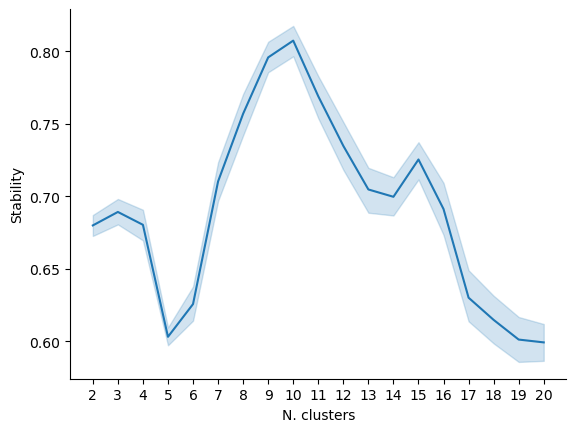

In [58]:
cc.pl.autok_stability(autok)

In [61]:
# ST_sample.obs['cluster_cellcharter'] = autok.predict(ST_sample, use_rep='X_cellcharter')
ST_sample.obs['cluster_cellcharter'] = autok.predict(ST_sample, use_rep='X_cellcharter', k=10) # Choose number of clusters

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.18it/s]


In [79]:
for tma in ST_sample.obs['TMA'].unique():
    ax = sq.pl.spatial_scatter(
        ST_sample,
        color=['cluster_cellcharter'],
        library_key='library_id',
        size=0.23,
        img=False,
        # img_res_key = "hires",
        spatial_key='spatial',
        palette='tab10',
        figsize=(5, 5),
        ncols=1,
        library_id=[tma],
        return_ax=True
    )

    # Save and close
    outpath = f"/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/spatial_scatter_{tma}.png"
    ax.figure.savefig(outpath, dpi=600, bbox_inches='tight')
    plt.close(ax.figure)  # <- Suppress inline display


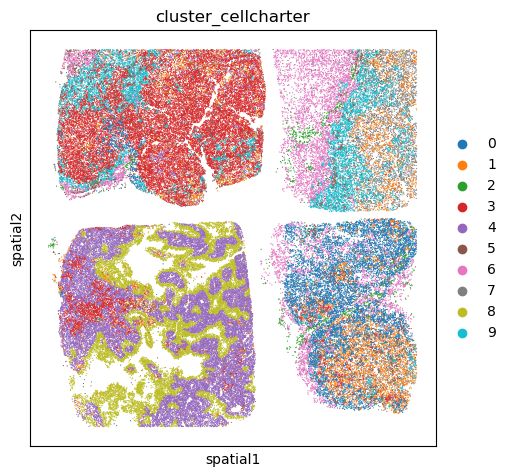

In [78]:
sq.pl.spatial_scatter(
    ST_sample, 
    color=['cluster_cellcharter'], 
    library_key='library_id',  
    size=0.3, 
    img=None,
    spatial_key='spatial',
    palette='tab10',
    figsize=(5,5),
    ncols=1,
    library_id=['F07839']
)

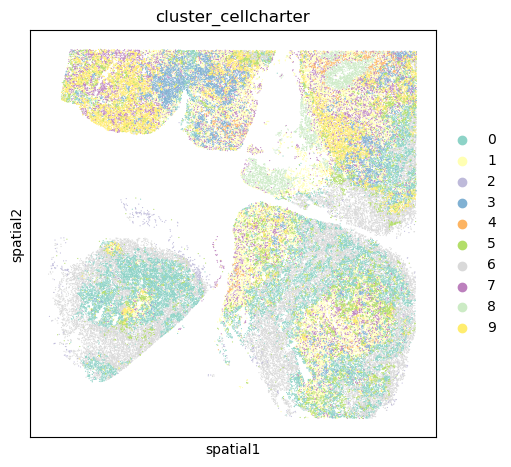

In [74]:
sq.pl.spatial_scatter(
    ST_sample, 
    color=['cluster_cellcharter'], 
    library_key='library_id',  
    size=0.3, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(5,5),
    ncols=1,
    library_id=['F07840']
)

In [71]:
ST_sample.write("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/onefer.h5ad")

# Visualizing Results

In [186]:
ST_sample.obs.columns

Index(['id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'mouse', 'sample_id', 'condition', 'cx',
       'cy', 'TMA', 'library_id', 'n_counts', '_scvi_batch', '_scvi_labels',
       'cluster_cellcharter'],
      dtype='object')

In [190]:
ST_sample.obs['condition'].unique()

['RTCyT72', 'RTCyPSCA', 'CyPSCA', 'NoTx', 'CyT72']
Categories (5, object): ['CyPSCA', 'CyT72', 'NoTx', 'RTCyPSCA', 'RTCyT72']

# Figuring out why cuda isn't visible

In [176]:
from cellcharter.tl import GaussianMixture

# Make sure you use "gpu" (not "cuda") for Lightning v2.x
gm = GaussianMixture(
    n_clusters=3,
    trainer_params={
        "accelerator": "gpu",   # for PL 2.x, "gpu" is correct
        "devices": 1,           # how many GPUs to use
        "enable_progress_bar": False
    }
)


In [177]:
trainer = gm.trainer()   # this returns the Lightning Trainer configured for GM
print("accelerator:", trainer.accelerator)
print("device_ids:", trainer.device_ids)
print("root_device:", trainer._device_type)


accelerator: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x769e6d7b21a0>
device_ids: [0]


AttributeError: 'Trainer' object has no attribute '_device_type'

## Working, but not recognizing cuda

In [168]:
import cellcharter
print(cellcharter.__version__)


0.3.4


In [174]:
import torch, lightning.pytorch as pl
print(torch.__version__, pl.__version__)

2.5.1+cu121 2.5.1.post0


In [172]:
# https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html?utm_source=chatgpt.com
model_params = {
    "random_state": 12345,
    "trainer_params": {
        "accelerator": "cuda",   # or "cuda" depending on PL version
        "devices": 1,          # number of GPUs to use
        "enable_progress_bar": True
    }
}


autok = cc.tl.ClusterAutoK(
    n_clusters=(2,20),
    max_runs=10,
    convergence_tol=0.001,
    model_class=cc.tl.GaussianMixture,
    model_params=model_params
)


In [173]:
autok.fit(ST_sample, 
          use_rep='X_cellcharter')

Iteration 1/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.00it/s, nll=19.90]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.87it/s]

  5%|███▊                                                                            | 1/21 [00:03<01:02,  3.11s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 13: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.90it/s, nll=19.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.92it/s]


 10%|███████▌                                                                        | 2/21 [00:04<00:43,  2.28s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 19: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.37it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.41it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:49,  2.77s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.07it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.95it/s]


 19%|███████████████▏                                                                | 4/21 [00:11<00:52,  3.10s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 41: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.56it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.24it/s]


 24%|███████████████████                                                             | 5/21 [00:13<00:43,  2.72s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.22it/s, nll=18.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.71it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:16<00:38,  2.55s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 69: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.73it/s, nll=18.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.26it/s]

 33%|██████████████████████████▋                                                     | 7/21 [00:18<00:35,  2.53s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.33it/s, nll=18.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.94it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:20<00:31,  2.41s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 77: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.51it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.08it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:24<00:35,  2.94s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.41it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.25it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:28<00:35,  3.18s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.67it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.28it/s]

 52%|█████████████████████████████████████████▍                                     | 11/21 [00:30<00:29,  2.91s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.46it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.24it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:34<00:28,  3.17s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 43: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.39it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.86it/s]

 62%|████████████████████████████████████████████████▉                              | 13/21 [00:36<00:22,  2.85s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.89it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 130.04it/s]

 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:40<00:21,  3.10s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.89it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.76it/s]

 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:42<00:17,  2.86s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.86it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.75it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:46<00:15,  3.12s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 107: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.82it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.05it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:50<00:14,  3.53s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.00it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.26it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:54<00:11,  3.68s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.06it/s, nll=17.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.44it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [00:58<00:07,  3.71s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.41it/s, nll=17.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.23it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:02<00:03,  3.81s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.30it/s, nll=17.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.67it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:06<00:00,  3.16s/it]


Iteration 2/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 106.98it/s, nll=19.90]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.52it/s]

  5%|███▊                                                                            | 1/21 [00:01<00:31,  1.60s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.66it/s, nll=19.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.10it/s]


 10%|███████▌                                                                        | 2/21 [00:04<00:47,  2.50s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.67it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.73it/s]


 14%|███████████▍                                                                    | 3/21 [00:06<00:40,  2.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.44it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.42it/s]


 19%|███████████████▏                                                                | 4/21 [00:10<00:48,  2.84s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.83it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.11it/s]


 24%|███████████████████                                                             | 5/21 [00:13<00:47,  2.97s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.37it/s, nll=18.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.68it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:17<00:46,  3.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.11it/s, nll=18.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.77it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:20<00:44,  3.20s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 93: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.49it/s, nll=18.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.05it/s]

 38%|██████████████████████████████▍                                                 | 8/21 [00:22<00:38,  2.98s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 77: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.85it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.39it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:26<00:39,  3.26s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 45: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.39it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.55it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:30<00:37,  3.42s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.91it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.60it/s]


 52%|█████████████████████████████████████████▍                                     | 11/21 [00:34<00:36,  3.60s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.21it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.78it/s]


 57%|█████████████████████████████████████████████▏                                 | 12/21 [00:38<00:33,  3.70s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 71: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.42it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.16it/s]

 62%|████████████████████████████████████████████████▉                              | 13/21 [00:42<00:30,  3.83s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.40it/s, nll=17.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.49it/s]


 67%|████████████████████████████████████████████████████▋                          | 14/21 [00:46<00:26,  3.80s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.40it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.22it/s]


 71%|████████████████████████████████████████████████████████▍                      | 15/21 [00:48<00:20,  3.36s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.83it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.51it/s]


 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [00:50<00:15,  3.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.92it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.75it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [00:54<00:13,  3.32s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 61: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.04it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.37it/s]


 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [00:57<00:09,  3.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.60it/s, nll=17.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.95it/s]


 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [01:01<00:06,  3.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 55: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.62it/s, nll=17.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.39it/s]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [01:05<00:03,  3.60s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.30it/s, nll=17.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.41it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.34s/it]


Iteration 3/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.44it/s, nll=19.90]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.02it/s]

  5%|███▊                                                                            | 1/21 [00:03<01:01,  3.07s/it]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.33it/s, nll=19.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.58it/s]


 10%|███████▌                                                                        | 2/21 [00:06<00:59,  3.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.75it/s, nll=18.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.60it/s]


 14%|███████████▍                                                                    | 3/21 [00:08<00:46,  2.56s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.14it/s, nll=18.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.54it/s]


 19%|███████████████▏                                                                | 4/21 [00:10<00:39,  2.32s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.65it/s, nll=18.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.56it/s]


 24%|███████████████████                                                             | 5/21 [00:13<00:44,  2.77s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.80it/s, nll=18.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.22it/s]


 29%|██████████████████████▊                                                         | 6/21 [00:17<00:44,  2.98s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.68it/s, nll=18.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.96it/s]


 33%|██████████████████████████▋                                                     | 7/21 [00:20<00:43,  3.11s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 39: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.64it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.46it/s]


 38%|██████████████████████████████▍                                                 | 8/21 [00:23<00:41,  3.21s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 49: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.73it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.61it/s]


 43%|██████████████████████████████████▎                                             | 9/21 [00:25<00:34,  2.86s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.49it/s, nll=17.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.15it/s]


 48%|█████████████████████████████████████▌                                         | 10/21 [00:28<00:28,  2.63s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 48%|█████████████████████████████████████▌                                         | 10/21 [00:30<00:33,  3.07s/it]


KeyboardInterrupt: 